#DCT-based Image Compression

Here we explore image compression using the Discrete Cosine Transform, as is used in some JPEG compression algorithms. Let's install graph learning and load the cameraman image.

Data type: float32
Pixel intensity range: (0,1)
(512, 512)


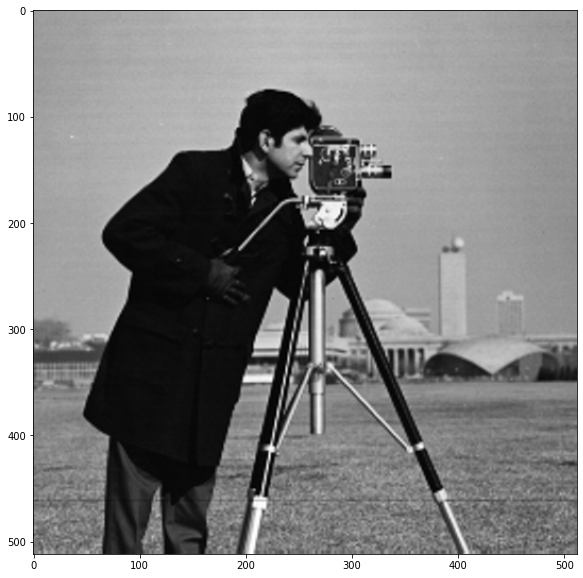

In [ ]:
import matplotlib.pyplot as plt

github = 'https://github.com/jwcalder/TestImages/raw/main/'
image = 'cameraman.png'

#Load image
I = plt.imread(github+image)
plt.figure(figsize=(10,10))
plt.imshow(I,cmap='gray')

#Check data type of image
print('Data type: '+str(I.dtype))
print('Pixel intensity range: (%d,%d)'%(I.min(),I.max()))

#Print image shape
print(I.shape)

Python does not have a 2D DCT or inverse DCT, so we have to write our own functions.

In [ ]:
from scipy.fftpack import dct
from scipy.fftpack import idct
import numpy as np

def dct2(f):
    """2D Discrete Cosine Transform

    Args:
        f: Square array

    Returns:
        2D DCT of f
    """
    return dct(dct(f, axis=0, norm='ortho' ),axis=1, norm='ortho')




def idct2(f):
    """2D Inverse Discrete Cosine Transform

    Args:
        f: Square array

    Returns:
        2D Inverse DCT of f
    """
    return idct(idct(f, axis=0 , norm='ortho'), axis=1 , norm='ortho')



We now view the DCT basis images for 8x8 image patches.

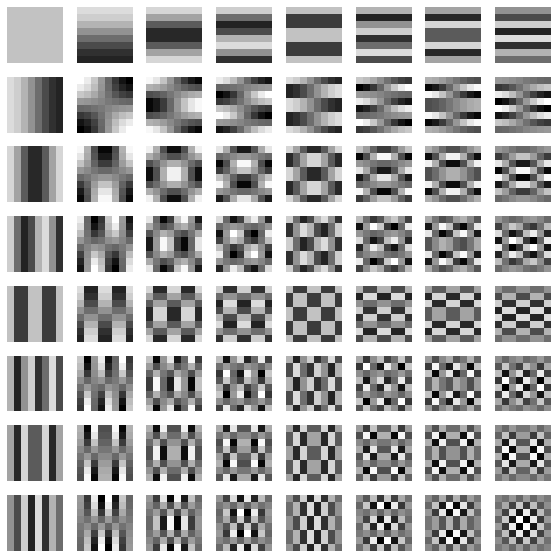

In [ ]:
import graphlearning as gl

dct_basis = np.zeros((64,64))
k = 0
for i in range(8):
    for j in range(8):
        g = np.zeros((8,8))
        g[i,j]=1
        dct_basis[k,:] = idct2(g).flatten()
        k+=1

dct_basis = dct_basis/np.max(np.absolute(dct_basis))
gl.utils.image_grid(dct_basis,n_rows=8,n_cols=8)


Let's now take the DCT of the patches in the image.



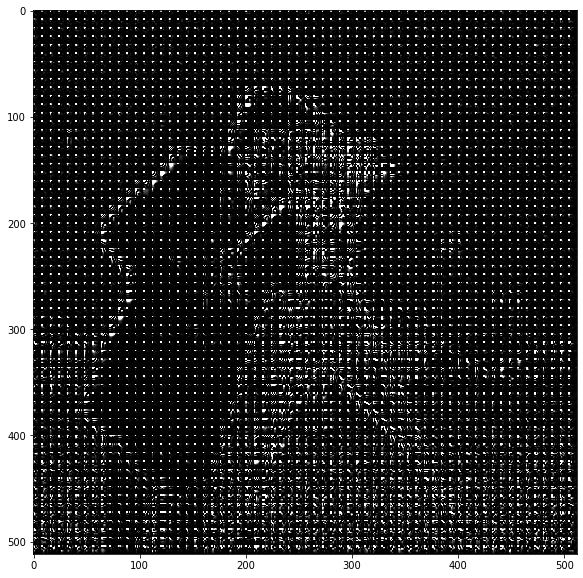

In [ ]:
patch_size = 8  #8x8 patch
I_dct = np.zeros_like(I)
for i in range(0,I.shape[0],patch_size):
    for j in range(0,I.shape[1],patch_size):
        I_dct[i:(i+patch_size),j:(j+patch_size)] = dct2(I[i:(i+patch_size),j:(j+patch_size)])

plt.figure(figsize=(10,10))
plt.imshow(I_dct,cmap='gray',vmin=0,vmax=np.max(I_dct)*0.01)


Let's now compress the image by thresholding the smaller coefficients to zero.

In [ ]:
thresh = 0.1
I_thresh = I_dct * (np.absolute(I_dct) > thresh*np.max(np.absolute(I_dct)))

We now decompress the image by taking the inverse DCT.

Keeping 1.53% of DCT coefficients
Compression ratio: 65.4:1
PSNR: 25.24 dB


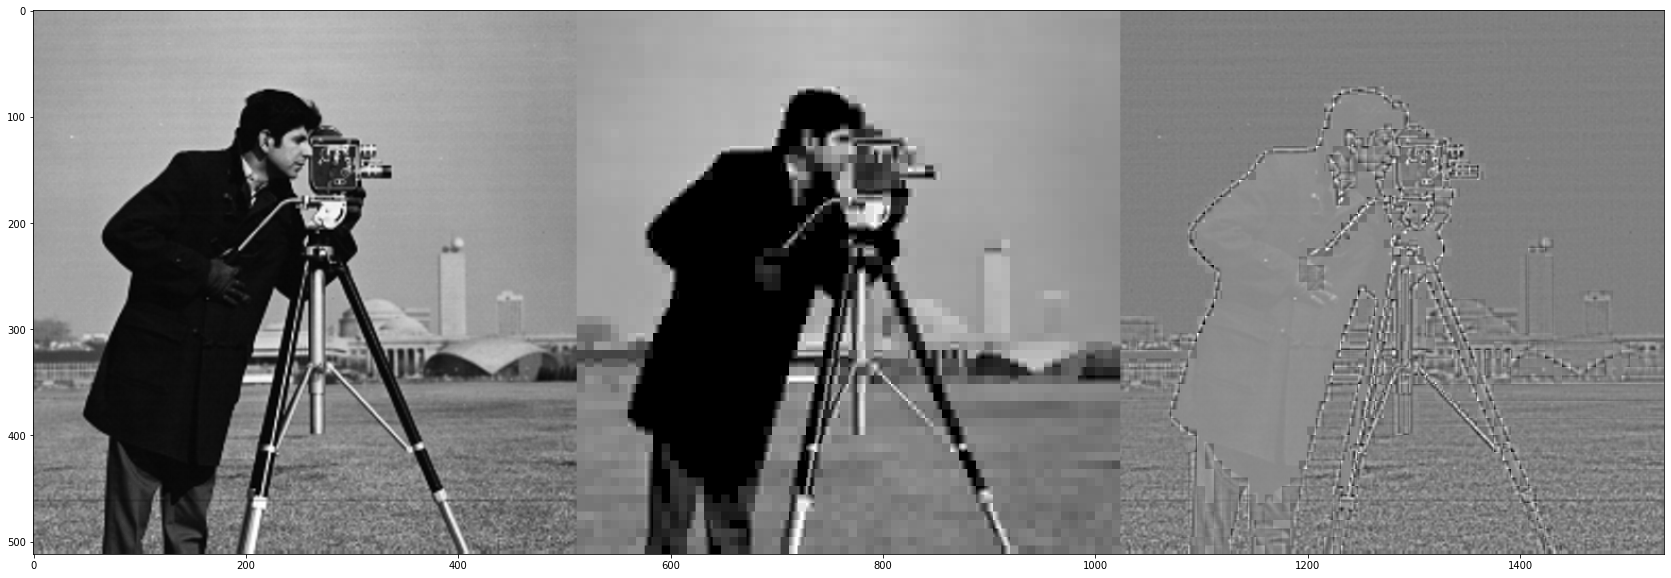

In [ ]:
patch_size = 8  #8x8 patch
I_comp = np.zeros_like(I)
for i in range(0,I.shape[0],patch_size):
    for j in range(0,I.shape[1],patch_size):
        I_comp[i:(i+patch_size),j:(j+patch_size)] = idct2(I_thresh[i:(i+patch_size),j:(j+patch_size)])

#Plot decompressed (reconstructed image)
plt.figure(figsize=(30,10))
plt.imshow(I_comp,cmap='gray')
plt.imshow(np.hstack((I,I_comp, I-I_comp+0.5)), cmap='gray', vmin=0, vmax=1)

#Compute size of compressed image and compression ratio
frac_nonzero = np.sum(I_thresh != 0.0)/I.size
print("Keeping %.2f%% of DCT coefficients"%(100*frac_nonzero))
print('Compression ratio: %.1f:1'%(1/frac_nonzero))

#Compute Peak Signal to Noise Ratio (PSNR)
MSE = np.sum((I-I_comp)**2)/I.size
PSNR = 10*np.log10(np.max(I)**2/MSE)
print('PSNR: %.2f dB'%PSNR)
